In [1]:
import torch
from torch.nn import CrossEntropyLoss

import transformers
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import TextClassificationPipeline
from transformers import TrainingArguments, Trainer

#Datahandeling
import numpy as np
import pandas as pd
import datasets
from datasets import Dataset
from datasets import load_metric,list_metrics
import spacy
import re

# GPU Flushing
import gc

# Evaluation
import seaborn as sns
import sklearn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce GTX 1060 3GB


In [3]:
train_test_ds= datasets.load_from_disk("../data/processed_data")
base_data = pd.read_csv("../data/labeled_data.csv")

In [4]:

MODEL_ARCHITECTURE = 'distilbert-base-uncased' 
# constant for classes
classes = ("hate","offensive","neither")
checkpoint_number = 6000
CHK_DIR = "../results/checkpoint-{}".format(checkpoint_number)
LAST_MODEL = "../results/last-model"

tokenizer = AutoTokenizer.from_pretrained(LAST_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=LAST_MODEL)#,output_attentions = True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [5]:

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    accuracy = load_metric("accuracy").compute(predictions=predictions, references=labels)
    precision = load_metric("precision").compute(predictions=predictions, references=labels,average="macro")
    f1 = load_metric("f1").compute(predictions=predictions, references=labels,average="macro")
    recall = load_metric("recall").compute(predictions=predictions, references=labels,average="macro")
    return {"accuracy":accuracy, "precision":precision, "recall":recall, "f1":f1}

training_args = TrainingArguments(
    output_dir="../results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    resume_from_checkpoint = None,
    #eval_steps = 500
)

#this is kind of an abuse of the Trainingclass to do the prediction on the entire test-data batched with calculation of metrics
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_test_ds["train"],
    eval_dataset=train_test_ds["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics = compute_metrics
)

In [6]:
gc.collect()
torch.cuda.empty_cache()
#1/0

In [7]:
predictions = trainer.predict(train_test_ds["test"])

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tweet.
***** Running Prediction *****
  Num examples = 2479
  Batch size = 8
100%|██████████| 310/310 [00:53<00:00,  5.95it/s]

In [8]:
#pipe = TextClassificationPipeline(model = model, tokenizer = tokenizer)

print(predictions.predictions.shape, predictions.label_ids.shape)

y_pred = np.argmax(predictions.predictions, axis=-1)
y_true = predictions.label_ids

(2479, 3) (2479,)


In [9]:

report = classification_report(y_true, y_pred )
print(report)

              precision    recall  f1-score   support

           0       0.58      0.64      0.61       134
           1       0.97      0.96      0.96      1899
           2       0.96      0.94      0.95       446

    accuracy                           0.94      2479
   macro avg       0.84      0.85      0.84      2479
weighted avg       0.94      0.94      0.94      2479



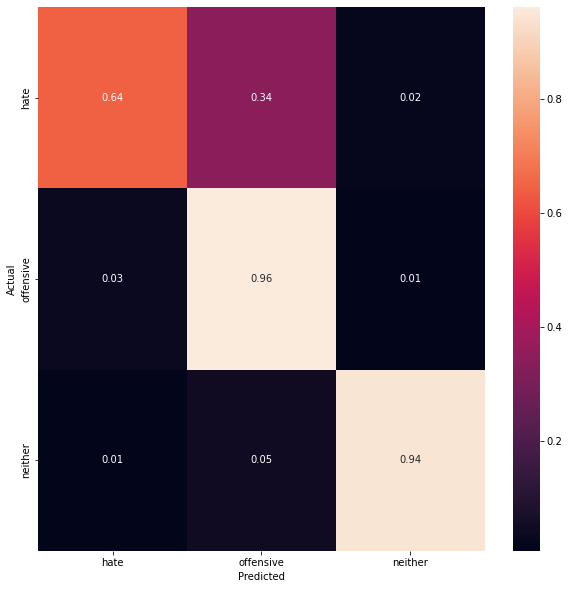

In [10]:

target_names = ("hate","offensive","neither")
cm = confusion_matrix(y_true=y_true,y_pred=y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

<AxesSubplot:>

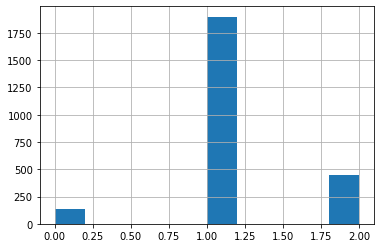

In [11]:
pd.Series(y_true).hist()

<AxesSubplot:>

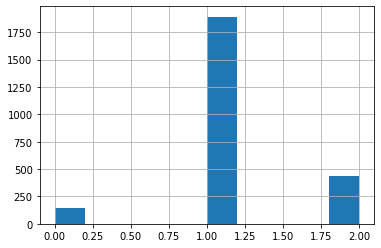

In [12]:
pd.Series(y_pred).hist()

In [39]:
output = predictions.predictions

In [40]:
nlp = spacy.load("en_core_web_sm")

def apply_regex(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '[URL]', parsed_text)
    parsed_text = re.sub(mention_regex, '[MENTION]', parsed_text)
    return parsed_text

def apply_stemming_and_stopwords(text_string):
    doc = nlp(text_string)
    processed_tokens = [token.lemma_ for token in doc if not token.is_stop]
    return " ".join(processed_tokens)

def preprocess_tweet(text_string):
    out_string = apply_stemming_and_stopwords(text_string)
    out_string = apply_regex(out_string)
    return out_string

In [41]:

ana_df  = pd.DataFrame(data=output,columns=["hate_out","offensive_out","neither_out"])
ana_df["hate_exp"] = np.exp(ana_df["hate_out"])
ana_df["offensive_exp"] = np.exp(ana_df["offensive_out"])
ana_df["neither_exp"] = np.exp(ana_df["neither_out"])

ana_df["exp_sum"] = ana_df.hate_exp + ana_df.offensive_exp + ana_df.neither_exp

ana_df["hate_%"] = ana_df["hate_exp"]/ana_df["exp_sum"]
ana_df["offensive_%"] = ana_df["offensive_exp"]/ana_df["exp_sum"]
ana_df["neither_%"] = ana_df["neither_exp"]/ana_df["exp_sum"]

ana_df["label"] = y_true
ana_df["pred_label"] = y_pred
#ana_df = ana_df[["hate_%","offensive_%","neither_%","label","pred_label"]]


In [34]:
class_weights = (1 - (base_data["class"].value_counts().sort_index()/len(base_data))).values
class_weights = torch.from_numpy(class_weights).float()
loss = CrossEntropyLoss(weight=class_weights)



In [107]:
loss = CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)

def row_loss(row):
    input = torch.as_tensor([row[["hate_out","offensive_out","neither_out"]].values])
    target = torch.tensor(data=[int(row["label"])], dtype=torch.long)
    return np.float(loss(input,target))

ana_df["loss"] = ana_df.apply(lambda row:row_loss(row),axis=1)

C:\Users\MEGAPORT\AppData\Local\Temp/ipykernel_5812/3811387232.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(loss(input,target))


In [111]:
ana_df.sort_values(by="loss",ascending=False)

,hate_out,offensive_out,neither_out,hate_exp,offensive_exp,neither_exp,exp_sum,hate_%,offensive_%,neither_%,label,pred_label,loss
1993,-2.635318,-0.650750,4.035047,0.071696,0.521655,56.545582,57.138931,0.001255,0.009130,0.989616,0,2,6.680804
2197,-1.316145,3.707137,-2.723731,0.268167,40.737022,0.065629,41.070816,0.006529,0.991873,0.001598,2,1,6.439029
960,-1.664649,3.821041,-2.376514,0.189257,45.651703,0.092874,45.933834,0.004120,0.993858,0.002022,2,1,6.203716
1398,-2.797082,-1.285932,4.879308,0.060988,0.276393,131.539581,131.876968,0.000462,0.002096,0.997442,1,2,6.167801
710,-1.948346,3.628124,-1.811399,0.142510,37.642143,0.163425,37.948078,0.003755,0.991938,0.004307,2,1,5.447618
...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,-2.687607,-1.720837,5.180147,0.068044,0.178916,177.708878,177.955841,0.000382,0.001005,0.998612,2,2,0.001389
725,-2.686767,-1.742694,5.165739,0.068101,0.175048,175.166870,175.410019,0.000388,0.000998,0.998614,2,2,0.001387
1051,-2.641587,-1.782278,5.151824,0.071248,0.168254,172.746292,172.985794,0.000412,0.000973,0.998616,2,2,0.001385
2316,-2.725149,-1.706496,5.189748,0.065536,0.181501,179.423294,179.670334,0.000365,0.001010,0.998625,2,2,0.001376


In [17]:
c_df = ana_df[ana_df.label != ana_df.pred_label]

In [18]:
c_df

,hate_%,offensive_%,neither_%,label,pred_label
13,0.203095,0.792968,0.003937,0,1
22,0.459300,0.539519,0.001181,0,1
40,0.922759,0.076324,0.000917,1,0
82,0.180841,0.817909,0.001250,0,1
116,0.867914,0.131087,0.000999,1,0
...,...,...,...,...,...
2412,0.133570,0.864411,0.002018,0,1
2413,0.106281,0.892723,0.000996,0,1
2429,0.541028,0.323271,0.135701,1,0
2450,0.726002,0.265436,0.008562,1,0


In [19]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

score = roc_auc_score(y_true=c_df["label"],y_score=c_df[["hate_%","offensive_%","neither_%"]],
                multi_class="ovo",average="weighted")

c_df["is_hate"] = (c_df.label == 0)
c_df["non_hate_%"] = c_df["offensive_%"] + c_df["neither_%"]
c_df.loc[c_df.is_hate.values,"roc_%"] = c_df.loc[c_df.is_hate.values,"hate_%"]
c_df.loc[np.logical_not(c_df.is_hate.values),"roc_%"] = c_df.loc[np.logical_not(c_df.is_hate.values),"non_hate_%"]
c_df.head()
fpr,tpr,threshhold = roc_curve(y_true=c_df.is_hate,y_score=c_df["roc_%"])
roc_auc = auc(fpr,tpr)


C:\Users\MEGAPORT\AppData\Local\Temp/ipykernel_4788/2050495285.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_df["is_hate"] = (c_df.label == 0)
C:\Users\MEGAPORT\AppData\Local\Temp/ipykernel_4788/2050495285.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_df["non_hate_%"] = c_df["offensive_%"] + c_df["neither_%"]
C:\Users\MEGAPORT\nlp\lib\site-packages\pandas\core\indexing.py:1681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

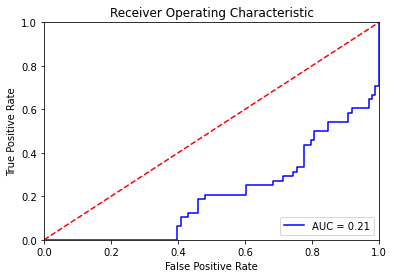

In [20]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [21]:
confused_tweets = train_test_ds["test"][c_df.index]["tweet"]
c_df["tweet"] = confused_tweets


C:\Users\MEGAPORT\AppData\Local\Temp/ipykernel_4788/1953239547.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_df["tweet"] = confused_tweets


In [22]:
c_df[(c_df["hate_%"] < 0.9) & (c_df["offensive_%"] < 0.9) & (c_df["neither_%"] < 0.9)]

,hate_%,offensive_%,neither_%,label,pred_label,is_hate,non_hate_%,roc_%,tweet
13,0.203095,0.792968,0.003937,0,1,True,0.796905,0.203095,@denytheprophecy thanks for ignoring my texts fag
22,0.459300,0.539519,0.001181,0,1,True,0.540700,0.459300,dumb ugly stupid bullshit ass bitch &#128074;&...
82,0.180841,0.817909,0.001250,0,1,True,0.819159,0.180841,It stinks in here must be then pussy ass nigga...
116,0.867914,0.131087,0.000999,1,0,False,0.132086,0.132086,@MichaelFraughto haha faggot
153,0.143811,0.762281,0.093908,2,1,False,0.856189,0.856189,@Scoob3y yeah and you're gonna play with retar...
...,...,...,...,...,...,...,...,...,...
2406,0.005552,0.395710,0.598738,1,2,False,0.994448,0.994448,&#8220;@_OneBadCreation: Boyfriends that'll ea...
2412,0.133570,0.864411,0.002018,0,1,True,0.866430,0.133570,RT @JHarmelink182: The fox says you're a cunt.
2413,0.106281,0.892723,0.000996,0,1,True,0.893719,0.106281,I like how niggas try an come at me and im lik...
2429,0.541028,0.323271,0.135701,1,0,False,0.458972,0.458972,RT @socass_: &#8220;@00sexilexi00: @socass_ I ...


In [23]:
hateful_gold_offensive_pred = c_df[(c_df.label == 0) & (c_df.pred_label == 1)].tweet

In [24]:
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=LAST_MODEL,output_attentions = True)

from bertviz import head_view

loading configuration file ../results/last-model\config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_attentions": true,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.12.5",
  "vocab_size": 30522
}

loading weights file ../results/last-model\pytorch_model.bin
All model checkpoint weights were used when initi

In [25]:
input_text = hateful_gold_offensive_pred.iloc[2]
inputs = tokenizer.encode(preprocess_tweet(input_text), return_tensors='pt')  # Tokenize input text
outputs = model(inputs)  # Run model
attention = outputs[-1]  # Retrieve attention from model outputs
tokens = tokenizer.convert_ids_to_tokens(inputs[0])  # Convert input ids to token strings
head_view(attention, tokens)  # Display model view

<IPython.core.display.Javascript object>

In [26]:
from bertviz import model_view

model_view(attention,tokens)

<IPython.core.display.Javascript object>